# differentiable Dynamic Programming 

This is a demo to make dynamic programming algorithm differentiable, with applications to compute distances between structured objects: time series, trajectories, trees, and graphs 

In [0]:
# Macros and libararies
from math import isinf
from numpy import array, zeros, full, argmin, inf, ndim
import numpy as np
import torch as T
import torch.nn as nn

## 1. First let's make a small DP game in pure python

In [0]:

def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

def dtw(x, y, dist, warp=1, w=inf, s=1.0):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    :param int w: window size limiting the maximal distance between indices of matched entries |i,j|.
    :param float s: weight applied on off-diagonal moves of the path. As s gets larger, the warping path is increasingly biased towards the diagonal
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not isinf(w):
        D0 = full((r + 1, c + 1), inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = zeros((r + 1, c + 1))
        D0[0, 1:] = inf
        D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i+k, r)
                j_k = min(j+k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

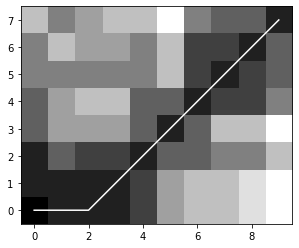

In [0]:
# We define two sequences x, y as numpy array
# where y is actually a sub-sequence from x
x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = np.array([1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)


euclidean_norm = lambda x, y: np.abs(x - y)

d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=euclidean_norm)


# You can also visualise the accumulated cost and the shortest path
import matplotlib.pyplot as plt

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

In [0]:
min(1,10)

1

## 2. Now lets try to make it differentiable 

use a smooth approximation of the min function, larger $\rho$, better approximation
$$f(x) = -\frac{1}{\rho}\log \frac{1}{N} \sum_{i=1}^N e^{-\rho x_i},$$

In [0]:
# this cannot handle inf, -\rho * x too big, e^{- \rho * x} close to 0
def smooth_min(x, rho=10):
  eps = 1e-12
  val =  -1/rho * T.log(T.mean(T.exp(x * (-rho))) + eps)
  assert val!=float('inf'), T.mean(T.exp(x * (-rho)))
  return val

rho = 10
x = T.tensor([100.0,  2.0231, 100.0])
print (smooth_min(x,rho))


# 1d min func is 1

tensor(2.1328)


In [0]:
# this will serve as a loss function 
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

def diff_dtw_loss(x, y, dist,warp=1, w=inf, s=1.0, rho=40):
    """ differentiable dtw, takes two sequences and
    compute the distance under the metric
    x, y is a tensor seq_len x dim
    dist is a bi-variate function
    """
    
    assert x.shape[0]
    assert y.shape[0]
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    

    MAX_VAL = 1e2
    
    r, c = x.shape[0], y.shape[0]
    if not isinf(w):
        D0 = T.full((r + 1, c + 1), MAX_VAL)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = T.zeros(r + 1, c + 1)
        D0[0, 1:] = MAX_VAL
        D0[1:, 0] = MAX_VAL
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist(x[i], y[j])
    C = D1.clone()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = D0[i, j]
            for k in range(1, warp + 1):
#                 print(i+k, r)
                i_k = min(i+k, r)
                j_k = min(j+k, c)
                min_list = T.cat((T.tensor([min_list]),  T.tensor([D0[i_k, j] * s]), T.tensor([D0[i, j_k] * s])))
                # Softmin is NOT a smooth min function
            min_val = smooth_min(min_list,rho)
            # print('min:', i, j, min_val, min_list)
            D1[i, j] = D1[i, j] + min_val
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path    
    

distance tensor(0.6806) diff distance: 0.6806224


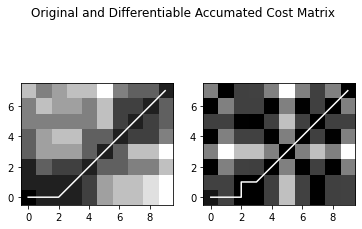

In [0]:
x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0], dtype=np.float32).reshape(-1, 1)
y = np.array([1, 1, 2, 4, 2, 1, 2, 0], dtype=np.float32).reshape(-1, 1)



tensor_x = T.from_numpy(x)
tensor_y = T.from_numpy(y)


euclidean_norm = lambda x, y: T.abs(x - y)

diff_d, diff_cost_matrix, diff_acc_cost_matrix, diff_path = diff_dtw_loss(tensor_x, tensor_y, dist=euclidean_norm)

print('distance', diff_d, 'diff distance:', diff_d.detach().numpy())
diff_acc_cost_matrix = diff_acc_cost_matrix.detach().numpy()
# print(acc_cost_matrix)


# You can also visualise the accumulated cost and the shortest path
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Original and Differentiable Accumated Cost Matrix')
ax1.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
ax1.plot(path[0], path[1], 'w')
ax2.imshow(diff_acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
ax2.plot(diff_path[0], diff_path[1], 'w')


# plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
# plt.plot(path[0], path[1], 'w')
# plt.show()

# 3. Wrap the diff_dtw_loss in a loss class 

In [0]:
import torch as T
from torch.nn import functional as F

from torch.nn.modules import Module

class _Loss(Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction


class DTW_Loss(_Loss):
  def __init__(self, rho=10, size_average=None, reduce=None, reduction='mean'):
    super(DTW_Loss, self).__init__(size_average, reduce, reduction)
    self.rho = rho

  def forward(self, input, target):
    # batch x seq_len x dim
    if ndim(input)==3:
      dist = []
      for b in range(input.size(0)):
          d_b, cost_matrix, diff_acc_cost_matrix, diff_path = diff_dtw_loss(input[b], target[b], dist=euclidean_norm, rho=rho) 
          dist.append(d_b)
      d = T.mean(T.tensor(dist))
    else: 
      d, cost_matrix, diff_acc_cost_matrix, diff_path = diff_dtw_loss(input, target, dist=euclidean_norm, rho=rho) 
    #F.mse_loss(input, target, reduction=self.reduction)
    loss_val =  d #.detach().numpy()
    return loss_val

x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0], dtype=np.float32).reshape(1, -1, 1)
y = np.array([1, 1, 2, 4, 2, 1, 2, 0], dtype=np.float32).reshape(1, -1, 1)

tensor_x = T.from_numpy(x)
tensor_y = T.from_numpy(y)
loss_vals = []

rhos = np.linspace(1, 10,10)
for rho in rhos:
  print(rho)
  my_loss = DTW_Loss(rho)
  loss_vals.append(my_loss(tensor_x, tensor_y))

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


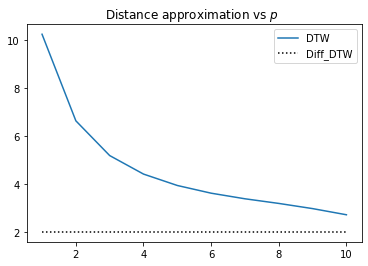

In [0]:
plt.plot(rhos, loss_vals)
plt.hlines(2, rhos[0], rhos[-1], linestyle='dotted')
plt.title('Distance approximation vs $p$  ')
plt.legend(['DTW', 'Diff_DTW'])

# Test on the sequence alignment task
learn sequence representations subject to the alignment loss 

In [0]:
path_name = "./sample_data/"
file_name = "GunPoint_TRAIN.txt"
# gun_point data has 150 time steps, binary class labels 

gun_point_x = []
gun_point_y = []

with open(path_name+file_name, 'r') as f:
  for line in f:
    tokens = line.split()
    vals = [float(token) for token in tokens]
    gun_point_x.append(np.asarray(vals[1:],dtype=float).reshape(-1,1))
    gun_point_y.append(vals[0])


print('total training point', len(gun_point_x))
print(len(gun_point_x[0]))

total training point 50
150


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the gun shot time series

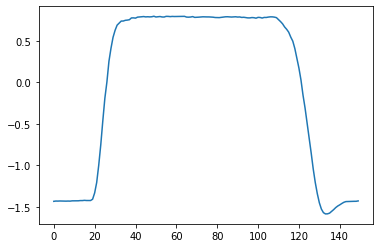

In [0]:
plt.plot(gun_point_x[49])

In [0]:
# Use the DTW loss to learn a generative model 
class NeuralNet(Module):
  def __init__(self):
      super(NeuralNet, self).__init__()
      # an encoder-decoder 
      self.fc1 = nn.Linear(150, 64)
      self.fc2 = nn.Linear(64, 10)
  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return x

net = NeuralNet()
print(net)

input= T.from_numpy(gun_point_x[0]).float().reshape(1,-1)
#input = T.randn(1, 150, 1) # first mode is batch size

output = net(input)
target = T.randn(1,10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output

criterion = DTW_Loss(rho)
output=output.reshape(1,-1).unsqueeze(2)
target=target.reshape(1,-1).unsqueeze(2)

loss = criterion(output, target)
print(loss)

NeuralNet(
  (fc1): Linear(in_features=150, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
tensor(2.8664)


## Now train the weights of the NN to minize diff_dtw loss

In [0]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()   # zero the gradient buffers
rho = 1
criterion = DTW_Loss(rho)

# in your training loop:
running_loss = 0.0

for i in range(10):
  input= T.from_numpy(gun_point_x[0]).float().reshape(1,-1)
  target = T.from_numpy(gun_point_x[2]).float().reshape(1,-1)
  output = net(input)

  output=output.reshape(1,-1).unsqueeze(2)
  target=target.reshape(1,-1).unsqueeze(2)

  loss = criterion(output, target)
  loss.requires_grad=True
  loss.backward()
  optimizer.step()    
  running_loss += loss.item()/(i+1) 
  print(running_loss)

27.675262451171875
41.51289367675781
50.73798116048177
57.65679677327474
63.19184926350912
67.8043930053711
71.75800192696708
75.21740973336357
78.29243889460489
81.05996513972207
